#  Classification model to Predict Grade 

## Problem Description
**Build a Classification model to predict grade for candidates and share the predicted grades for the given test data.**

#### Import Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy
import statsmodels
from IPython.core.pylabtools import figsize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
# Imputing missing values and scaling values
from sklearn.preprocessing import Imputer, MinMaxScaler
from collections import Counter

In [2]:
path='H:\IITM\Documents\Resume\Rushi_ML\Delloite\Predict-Grade'

In [3]:
import os
os.chdir(path)

## Understanding the data

###  Data Exploration

In [4]:
# Read in the data set
df = pd.read_csv('Train_data.csv')
df.head()

,Sex,Age,Height,Weight,Team,Federation,Event,Year,Season,City,Sub Event,Grade,Id,GameID,Game,Record_Id
0,M,31.0,188.0,138.0,Bulgaria,BUL,2016 Summer,2016,down,Rio de Janeiro,Athletics Men's Shot Put,D+,candidate-40730,Game 1,Athletics,5da57331-62fe-418b-abfd-ca6ab0731709
1,F,28.0,166.0,62.0,Chinese Taipei,TPE,1996 Summer,1996,down,Atlanta,Table Tennis Women's Singles,D+,candidate-129936,Game 33,Table Tennis,0ae393f7-5e07-4b7c-b0cd-83edf259a069
2,M,30.0,NaN,NaN,Sweden,SWE,1960 Summer,1960,down,Roma,Rowing Men's Coxed Fours,D+,candidate-109667,Game 7,Rowing,3fec3204-ca6d-476f-ab89-e1189bc0eb35
3,F,28.0,181.0,80.0,China,CHN,2004 Summer,2004,down,Athina,Handball Women's Handball,D+,candidate-131637,Game 24,Handball,96cd09eb-b394-4c7d-8f7d-b3a0dc8cd870
4,F,16.0,175.0,54.0,Hungary,HUN,1996 Summer,1996,down,Atlanta,Swimming Women's 4 x 100 metres Medley Relay,D+,candidate-29360,Game 3,Swimming,bc158ecb-2fc5-4ffa-abd3-1075f4196044


In [5]:
df.shape

(90725, 16)

In [6]:
df.columns

Index(['Sex', 'Age', 'Height', 'Weight', 'Team', 'Federation', 'Event', 'Year',
       'Season', 'City', 'Sub Event', 'Grade', 'Id', 'GameID', 'Game',
       'Record_Id'],
      dtype='object')

## Atrribute information

**There are 16 attributes in 90725 case of the dataset. **

**Data set is having continuous and catagerical variables**

**Output**: Grade

**Grade is categorical variable **

## Data cleaning

### Missing values

In [7]:
print(df.isnull().sum())

Sex               0
Age            3174
Height        19883
Weight        20792
Team              0
Federation        0
Event             0
Year              0
Season            0
City              0
Sub Event         0
Grade             0
Id                0
GameID            0
Game              0
Record_Id         0
dtype: int64


In [8]:
print(df.loc[:, ['Federation', 'Team']].drop_duplicates()['Federation'].value_counts().head())

FRA    94
USA    76
GBR    67
SWE    40
NOR    39
Name: Federation, dtype: int64


In [9]:
# Lets read in the Federation_country mapping first
federation_country = pd.read_csv('Federation Data.csv')
federation_country.rename(columns = {'Region':'Country'}, inplace = True)

federation_country.head()

,Federation,Country
0,AFG,Afghanistan
1,AHO,Curacao
2,ALB,Albania
3,ALG,Algeria
4,AND,Andorra


In [10]:
df_merge = df.merge(federation_country,
                                left_on = 'Federation',
                                right_on = 'Federation',
                                how = 'left')

In [11]:
# Put these values from Country into Team
df_merge.drop('Team', axis = 1, inplace = True)
df_merge.rename(columns = {'Country': 'Team'}, inplace = True)

In [12]:
# Glance at the data.
w_gdp = pd.read_csv('world_gdp.csv', skiprows = 3)

# Remove unnecessary columns
w_gdp.drop(['Indicator Name', 'Indicator Code'], axis = 1, inplace = True)

# The columns are the years for which the GDP has been recorded. This needs to brought into a single column for efficient
# merging.
w_gdp = pd.melt(w_gdp, id_vars = ['Country Name', 'Country Code'], var_name = 'Year', value_name = 'GDP')

# convert the year column to numeric
w_gdp['Year'] = pd.to_numeric(w_gdp['Year'])

w_gdp.head()

,Country Name,Country Code,Year,GDP
0,Afghanistan,AFG,1960,5.377778e+08
1,Albania,ALB,1960,NaN
2,Algeria,DZA,1960,2.723649e+09
3,American Samoa,ASM,1960,NaN
4,Andorra,AND,1960,NaN


In [13]:
# Merge to get country code
df_merge_ccode = df_merge.merge(w_gdp[['Country Name', 'Country Code']].drop_duplicates(),
                                            left_on = 'Team',
                                            right_on = 'Country Name',
                                            how = 'left')

df_merge_ccode.drop('Country Name', axis = 1, inplace = True)

# Merge to get gdp too
df_merge_gdp = df_merge_ccode.merge(w_gdp,
                                                left_on = ['Country Code', 'Year'],
                                                right_on = ['Country Code', 'Year'],
                                                how = 'left')

df_merge_gdp.drop('Country Name', axis = 1, inplace = True)

In [14]:
# Read in the population data
w_pop = pd.read_csv('world_pop.csv')

w_pop.drop(['Indicator Name', 'Indicator Code'], axis = 1, inplace = True)

w_pop = pd.melt(w_pop, id_vars = ['Country', 'Country Code'], var_name = 'Year', value_name = 'Population')

# Change the Year to integer type
w_pop['Year'] = pd.to_numeric(w_pop['Year'])

w_pop.head()

,Country,Country Code,Year,Population
0,Aruba,ABW,1960,54211.0
1,Afghanistan,AFG,1960,8996351.0
2,Angola,AGO,1960,5643182.0
3,Albania,ALB,1960,1608800.0
4,Andorra,AND,1960,13411.0


In [15]:
df_complete = df_merge_gdp.merge(w_pop,
                                            left_on = ['Country Code', 'Year'],
                                            right_on= ['Country Code', 'Year'],
                                            how = 'left')

df_complete.drop('Country', axis = 1, inplace = True)

df_complete.head()

,Sex,Age,Height,Weight,Federation,Event,Year,Season,City,Sub Event,Grade,Id,GameID,Game,Record_Id,Team,Country Code,GDP,Population
0,M,31.0,188.0,138.0,BUL,2016 Summer,2016,down,Rio de Janeiro,Athletics Men's Shot Put,D+,candidate-40730,Game 1,Athletics,5da57331-62fe-418b-abfd-ca6ab0731709,Bulgaria,BGR,5.323788e+10,7.127822e+06
1,F,28.0,166.0,62.0,TPE,1996 Summer,1996,down,Atlanta,Table Tennis Women's Singles,D+,candidate-129936,Game 33,Table Tennis,0ae393f7-5e07-4b7c-b0cd-83edf259a069,Taiwan,NaN,NaN,NaN
2,M,30.0,NaN,NaN,SWE,1960 Summer,1960,down,Roma,Rowing Men's Coxed Fours,D+,candidate-109667,Game 7,Rowing,3fec3204-ca6d-476f-ab89-e1189bc0eb35,Sweden,SWE,1.484287e+10,7.484656e+06
3,F,28.0,181.0,80.0,CHN,2004 Summer,2004,down,Athina,Handball Women's Handball,D+,candidate-131637,Game 24,Handball,96cd09eb-b394-4c7d-8f7d-b3a0dc8cd870,China,CHN,1.955350e+12,1.296075e+09
4,F,16.0,175.0,54.0,HUN,1996 Summer,1996,down,Atlanta,Swimming Women's 4 x 100 metres Medley Relay,D+,candidate-29360,Game 3,Swimming,bc158ecb-2fc5-4ffa-abd3-1075f4196044,Hungary,HUN,4.665980e+10,1.031124e+07


In [16]:
df_complete.isnull().sum()

Sex                 0
Age              3174
Height          19883
Weight          20792
Federation          0
Event               0
Year                0
Season              0
City                0
Sub Event           0
Grade               0
Id                  0
GameID              0
Game                0
Record_Id           0
Team              118
Country Code      575
GDP             29038
Population      21700
dtype: int64

#### From above, we can observe, 6 variable having missing data 

In [17]:
df_complete

,Sex,Age,Height,Weight,Federation,Event,Year,Season,City,Sub Event,Grade,Id,GameID,Game,Record_Id,Team,Country Code,GDP,Population
0,M,31.0,188.0,138.0,BUL,2016 Summer,2016,down,Rio de Janeiro,Athletics Men's Shot Put,D+,candidate-40730,Game 1,Athletics,5da57331-62fe-418b-abfd-ca6ab0731709,Bulgaria,BGR,5.323788e+10,7.127822e+06
1,F,28.0,166.0,62.0,TPE,1996 Summer,1996,down,Atlanta,Table Tennis Women's Singles,D+,candidate-129936,Game 33,Table Tennis,0ae393f7-5e07-4b7c-b0cd-83edf259a069,Taiwan,NaN,NaN,NaN
2,M,30.0,NaN,NaN,SWE,1960 Summer,1960,down,Roma,Rowing Men's Coxed Fours,D+,candidate-109667,Game 7,Rowing,3fec3204-ca6d-476f-ab89-e1189bc0eb35,Sweden,SWE,1.484287e+10,7.484656e+06
3,F,28.0,181.0,80.0,CHN,2004 Summer,2004,down,Athina,Handball Women's Handball,D+,candidate-131637,Game 24,Handball,96cd09eb-b394-4c7d-8f7d-b3a0dc8cd870,China,CHN,1.955350e+12,1.296075e+09
4,F,16.0,175.0,54.0,HUN,1996 Summer,1996,down,Atlanta,Swimming Women's 4 x 100 metres Medley Relay,D+,candidate-29360,Game 3,Swimming,bc158ecb-2fc5-4ffa-abd3-1075f4196044,Hungary,HUN,4.665980e+10,1.031124e+07
5,M,41.0,NaN,NaN,SWE,1948 Summer,1948,down,London,"Fencing Men's epee, Team",C+,candidate-37265,Game 6,Fencing,8daeb6f5-bda4-4af9-925a-f3ad3f761352,Sweden,SWE,NaN,NaN
6,M,19.0,NaN,NaN,GER,1900 Summer,1900,down,Paris,Water Polo Men's Water Polo,D+,candidate-48666,Game 22,Water Polo,0e2ca9d3-ba39-4205-b4ab-11fa3de643d1,Germany,DEU,NaN,NaN
7,F,21.0,183.0,69.0,GER,2012 Summer,2012,down,London,Rowing Women's Coxed Eights,D+,candidate-68163,Game 7,Rowing,b3966071-9051-49cf-88ab-ef8705e43f6f,Germany,DEU,3.543980e+12,8.042582e+07
8,M,33.0,NaN,NaN,FRA,1900 Summer,1900,down,Paris,"Fencing Men's epee, Masters and Amateurs, Indi...",D+,candidate-41837,Game 6,Fencing,cbe726dc-8d26-4e49-82a5-8ecdbe45c7ff,France,FRA,NaN,NaN
9,M,21.0,174.0,57.0,GER,2010 Winter,2010,Up,Vancouver,Nordic Combined Men's Team,C+,candidate-32501,Game 38,Nordic Combined,a0e57be0-22bd-49d2-a25c-032d278e14d2,Germany,DEU,3.417090e+12,8.177693e+07


In [18]:
# Lets take data from 1961 onwards only and for summer df only
#df_complete_subset = df_complete.loc[(df_complete['Year'] > 1960) & (df_complete['Season'] == "Summer"), :]

## Exploratory data analysis

### Univariate Analysis

#### Population and GDP data  are available from 1961 onwards while training data is from 1896. Therefore, let's consider only data from 1961 onwards.

In [19]:
df_complete_subset = df_complete.loc[(df_complete['Year'] >= 1961), :]

In [20]:
df_complete_subset.head(10)

,Sex,Age,Height,Weight,Federation,Event,Year,Season,City,Sub Event,Grade,Id,GameID,Game,Record_Id,Team,Country Code,GDP,Population
0,M,31.0,188.0,138.0,BUL,2016 Summer,2016,down,Rio de Janeiro,Athletics Men's Shot Put,D+,candidate-40730,Game 1,Athletics,5da57331-62fe-418b-abfd-ca6ab0731709,Bulgaria,BGR,5.323788e+10,7.127822e+06
1,F,28.0,166.0,62.0,TPE,1996 Summer,1996,down,Atlanta,Table Tennis Women's Singles,D+,candidate-129936,Game 33,Table Tennis,0ae393f7-5e07-4b7c-b0cd-83edf259a069,Taiwan,NaN,NaN,NaN
3,F,28.0,181.0,80.0,CHN,2004 Summer,2004,down,Athina,Handball Women's Handball,D+,candidate-131637,Game 24,Handball,96cd09eb-b394-4c7d-8f7d-b3a0dc8cd870,China,CHN,1.955350e+12,1.296075e+09
4,F,16.0,175.0,54.0,HUN,1996 Summer,1996,down,Atlanta,Swimming Women's 4 x 100 metres Medley Relay,D+,candidate-29360,Game 3,Swimming,bc158ecb-2fc5-4ffa-abd3-1075f4196044,Hungary,HUN,4.665980e+10,1.031124e+07
7,F,21.0,183.0,69.0,GER,2012 Summer,2012,down,London,Rowing Women's Coxed Eights,D+,candidate-68163,Game 7,Rowing,b3966071-9051-49cf-88ab-ef8705e43f6f,Germany,DEU,3.543980e+12,8.042582e+07
9,M,21.0,174.0,57.0,GER,2010 Winter,2010,Up,Vancouver,Nordic Combined Men's Team,C+,candidate-32501,Game 38,Nordic Combined,a0e57be0-22bd-49d2-a25c-032d278e14d2,Germany,DEU,3.417090e+12,8.177693e+07
11,M,27.0,175.0,72.0,NOR,1980 Winter,1980,Up,Lake Placid,Ice Hockey Men's Ice Hockey,D+,candidate-90321,Game 17,Ice Hockey,b878894b-426c-42f1-a7f9-3742d034e9fa,Norway,NOR,6.443938e+10,4.085620e+06
12,M,21.0,167.0,67.0,GDR,1980 Summer,1980,down,Moskva,Gymnastics Men's Individual All-Around,D+,candidate-78430,Game 2,Gymnastics,b2207b51-d1fc-4ae5-949c-cd6adac6214d,Germany,DEU,9.466950e+11,7.828858e+07
13,M,19.0,186.0,78.0,GER,2008 Summer,2008,down,Beijing,Table Tennis Men's Team,B+,candidate-27298,Game 33,Table Tennis,e900c123-aad8-4854-9b0a-a1990167e7b0,Germany,DEU,3.752370e+12,8.211010e+07
14,M,21.0,NaN,NaN,KOR,1996 Summer,1996,down,Atlanta,Gymnastics Men's Horse Vault,D+,candidate-69882,Game 2,Gymnastics,4b09a073-c3ab-4766-82d7-8630d60729d2,South Korea,KOR,5.980990e+11,4.552468e+07


In [21]:
df_complete_subset.shape

(67088, 19)

In [22]:
df_complete_subset = df_complete_subset.reset_index()

In [23]:
df_complete_subset.shape

(67088, 20)

In [24]:
df_complete_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67088 entries, 0 to 67087
Data columns (total 20 columns):
index           67088 non-null int64
Sex             67088 non-null object
Age             66809 non-null float64
Height          63671 non-null float64
Weight          63458 non-null float64
Federation      67088 non-null object
Event           67088 non-null object
Year            67088 non-null int64
Season          67088 non-null object
City            67088 non-null object
Sub Event       67088 non-null object
Grade           67088 non-null object
Id              67088 non-null object
GameID          67088 non-null object
Game            67088 non-null object
Record_Id       67088 non-null object
Team            66992 non-null object
Country Code    66556 non-null object
GDP             59606 non-null float64
Population      66034 non-null float64
dtypes: float64(5), int64(2), object(13)
memory usage: 10.2+ MB


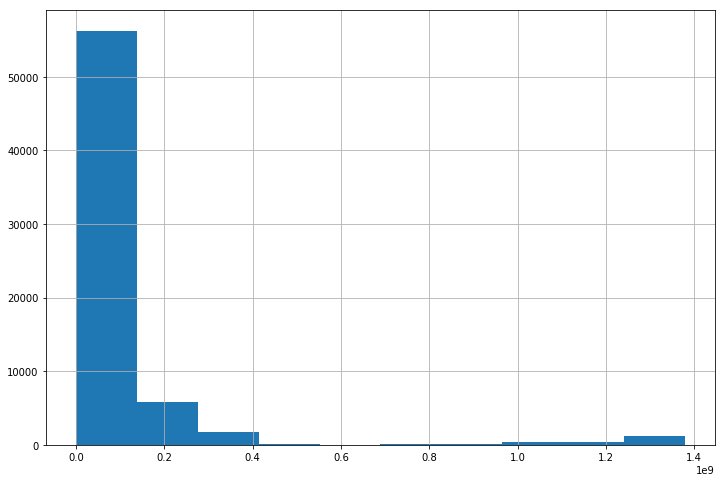

In [25]:
figsize(12, 8)
df_complete_subset['Population'].hist(bins = 10)

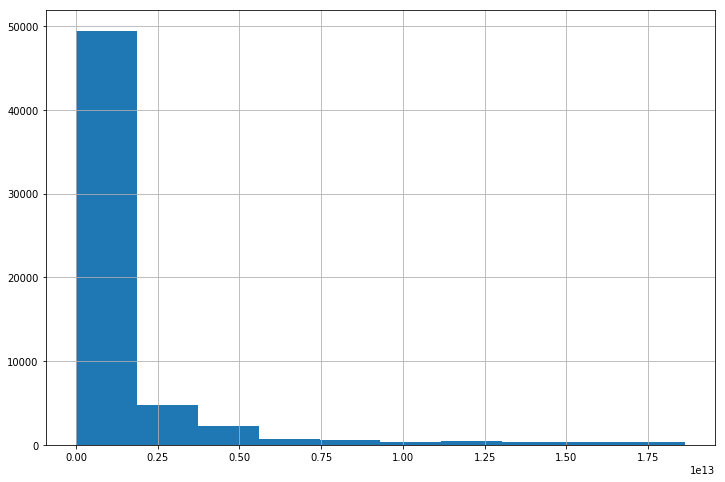

In [26]:
df_complete_subset['GDP'].hist(bins = 10)

#### We can observed, GDP and Populations are highly right skewed, hence we can take log transform of feature


In [27]:
import math
# take the log transforms for the variables
df_complete_subset['Log_Population'] = np.log(df_complete_subset['Population'])
df_complete_subset['Log_GDP'] = np.log(df_complete_subset['GDP'])

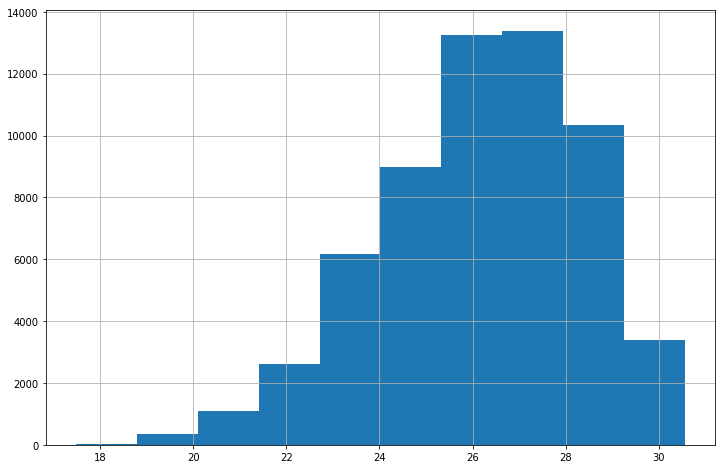

In [28]:
df_complete_subset['Log_GDP'].hist()

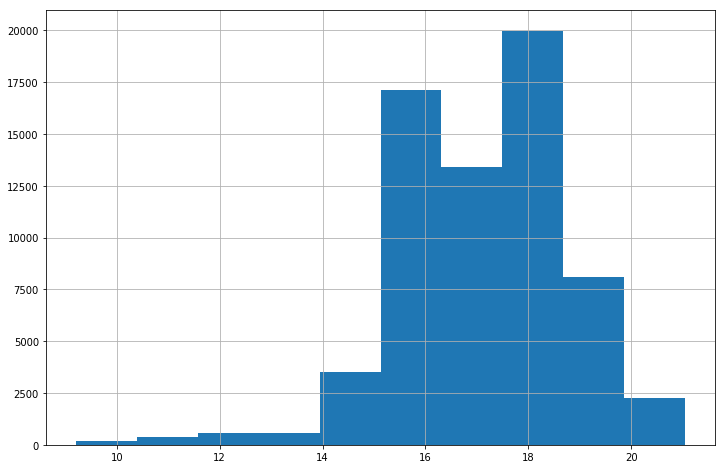

In [29]:
df_complete_subset['Log_Population'].hist()

In [30]:
from collections import Counter
Counter(df_complete_subset['Grade'])

Counter({'A+': 3019, 'B+': 2976, 'C+': 3099, 'D+': 57994})

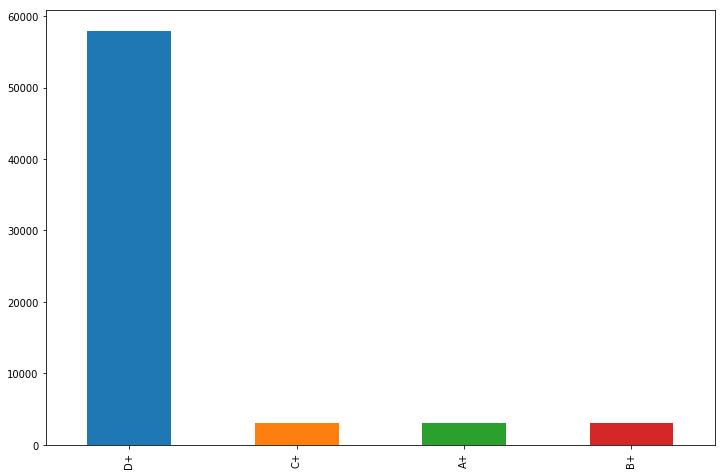

In [31]:
df_complete_subset['Grade'].value_counts().plot(kind='bar')

#### We can observed that data is imbalanced. Class D+ has major count in total dataset

Counter({'M': 44452, 'F': 22636})


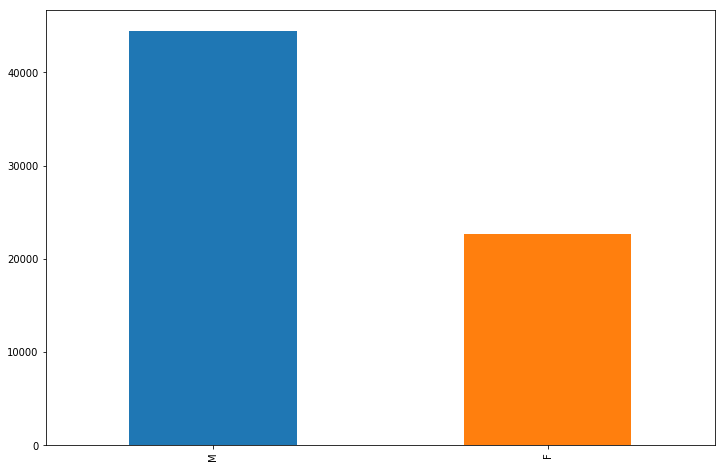

In [32]:
print(Counter(df_complete_subset['Sex']))
df_complete_subset['Sex'].value_counts().plot(kind='bar')

#### We can observed Male has higher number participations (44452), compared to femal candidate (22636)

Counter({'down': 53055, 'Up': 14033})


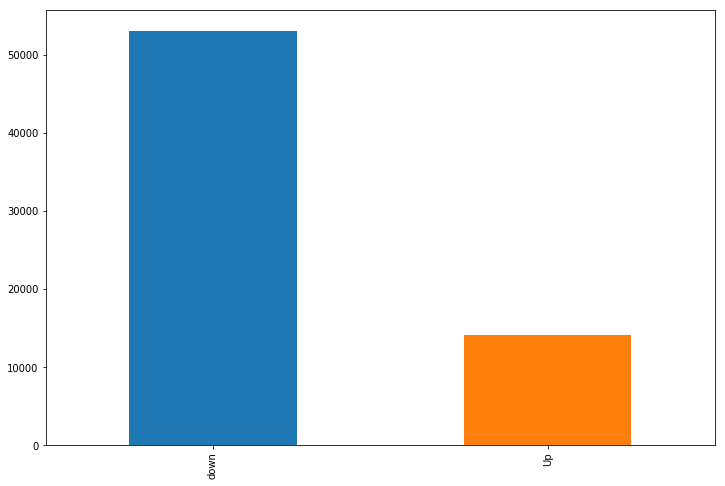

In [33]:
print(Counter(df_complete_subset['Season']))
df_complete_subset['Season'].value_counts().plot(kind='bar')

#### We can observed, Down has higher number participations (53055), compared to Up Season (14033)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AF66A91710>,
      dtype=object)

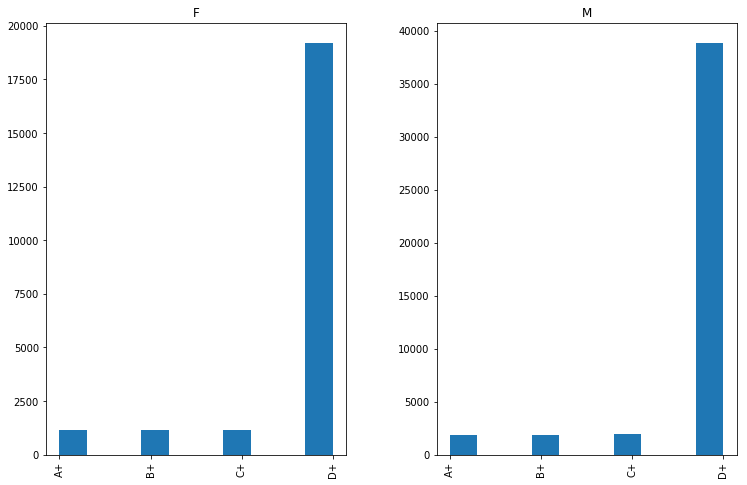

In [34]:
df_complete_subset['Grade'].hist(by=df_complete_subset['Sex'])

#### From above, for both male and female category, 'D+' category has higest count

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AF6705AC50>,
      dtype=object)

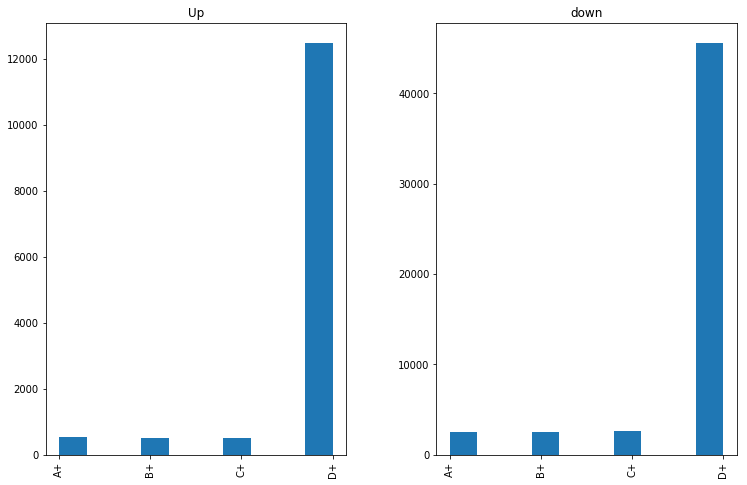

In [35]:
df_complete_subset['Grade'].hist(by=df_complete_subset['Season'])

In [36]:
df_complete_subset.head()

,index,Sex,Age,Height,Weight,Federation,Event,Year,Season,City,...,Id,GameID,Game,Record_Id,Team,Country Code,GDP,Population,Log_Population,Log_GDP
0,0,M,31.0,188.0,138.0,BUL,2016 Summer,2016,down,Rio de Janeiro,...,candidate-40730,Game 1,Athletics,5da57331-62fe-418b-abfd-ca6ab0731709,Bulgaria,BGR,5.323788e+10,7.127822e+06,15.779516,24.698036
1,1,F,28.0,166.0,62.0,TPE,1996 Summer,1996,down,Atlanta,...,candidate-129936,Game 33,Table Tennis,0ae393f7-5e07-4b7c-b0cd-83edf259a069,Taiwan,NaN,NaN,NaN,NaN,NaN
2,3,F,28.0,181.0,80.0,CHN,2004 Summer,2004,down,Athina,...,candidate-131637,Game 24,Handball,96cd09eb-b394-4c7d-8f7d-b3a0dc8cd870,China,CHN,1.955350e+12,1.296075e+09,20.982606,28.301590
3,4,F,16.0,175.0,54.0,HUN,1996 Summer,1996,down,Atlanta,...,candidate-29360,Game 3,Swimming,bc158ecb-2fc5-4ffa-abd3-1075f4196044,Hungary,HUN,4.665980e+10,1.031124e+07,16.148745,24.566149
4,7,F,21.0,183.0,69.0,GER,2012 Summer,2012,down,London,...,candidate-68163,Game 7,Rowing,b3966071-9051-49cf-88ab-ef8705e43f6f,Germany,DEU,3.543980e+12,8.042582e+07,18.202846,28.896272


In [37]:
df_complete_subset_class=df_complete_subset.copy()

In [39]:
Counter(df_complete_subset_class['Grade'])

Counter({'A+': 3019, 'B+': 2976, 'C+': 3099, 'D+': 57994})

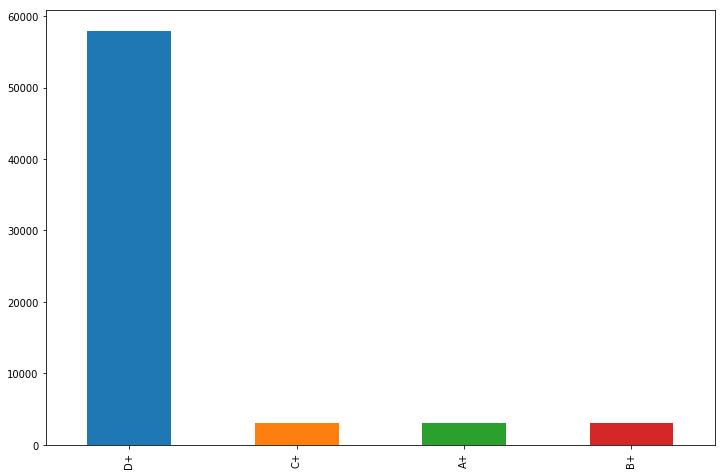

In [38]:
df_complete_subset_class['Grade'].value_counts().plot(kind='bar')

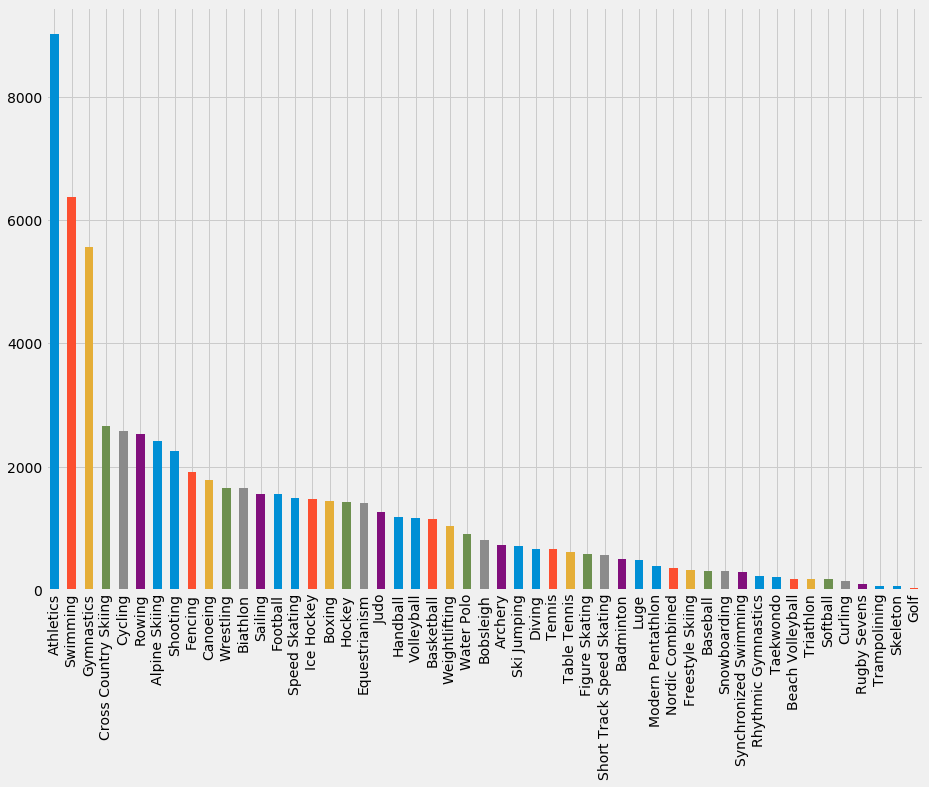

In [103]:
figsize(14, 10)
df_complete_subset_class['Game'].value_counts().plot(kind='bar')

#### We can oberved that, Athletics has higher number of participation followed by swimming and Gymnastics

### Splitting into Training & Test sets
In machine learning, we always need to separate our features into two sets:

Training set which we provide to our model during training along with the answers so it can learn a mapping between the features and the target.

Testing set which we use to evaluate the mapping learned by the model. The model has never seen the answers on the testing set, but instead, must make predictions using only the features. As we know the true answers for the test set, we can then compare the test predictions to the true test targets to get an estimate of how well our model will perform when deployed in the real world.

For our problem, we will first extract below feature without Grade. Then, we will split the training data with a Grade into a testing set of 20% , and a training set of 80%.
- Sex
- Age
- Height
- Weight
- Log_Population
- Log_GDP

In [40]:
df_complete_subset_filter=df_complete_subset_class[['Sex', 'Age', 'Height', 'Weight','Log_Population', 'Log_GDP']]

In [41]:
df_complete_subset_filter.head()

,Sex,Age,Height,Weight,Log_Population,Log_GDP
0,M,31.0,188.0,138.0,15.779516,24.698036
1,F,28.0,166.0,62.0,NaN,NaN
2,F,28.0,181.0,80.0,20.982606,28.301590
3,F,16.0,175.0,54.0,16.148745,24.566149
4,F,21.0,183.0,69.0,18.202846,28.896272


- 	List down the features including any engineered features that are significant for classification
    Below are the featured consider for classification
    - Sex
    - Age
    - Height
    - Weight
    - Population
    - GDP


In [42]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [43]:
df_complete_subset_filter['Sex_encode']=label_encoder.fit_transform(df_complete_subset_filter['Sex'])
df_complete_subset_filter.head()
df_complete_subset_filter=df_complete_subset_filter.drop(columns='Sex')

C:\Users\Rushikesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [44]:
print(df_complete_subset_filter.isnull().sum())

Age                279
Height            3417
Weight            3630
Log_Population    1054
Log_GDP           7482
Sex_encode           0
dtype: int64


#### Data having more missing values. We can filled missing values with medium imputer strategy

# Classification

## Metric : Confusion metrics
In this case, because we are doing classification, the confusion metric is an appropriate metric. This is also interpretable because it represents the precesion, recall and F1 score.

In [45]:
# Create an imputer object with a median filling strategy
imputer = Imputer(strategy='median')

In [46]:
df_complete_subset_filter.columns

Index(['Age', 'Height', 'Weight', 'Log_Population', 'Log_GDP', 'Sex_encode'], dtype='object')

In [47]:
x= df_complete_subset_filter.iloc[:,:].values
y=df_complete_subset_class['Grade'].values

In [48]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2,random_state=0)

In [49]:
# Create an imputer object with a median filling strategy
imputer = Imputer(strategy='median')

# Train on the training features
imputer.fit(x_train)

# Transform both training data and testing data
x_train = imputer.transform(x_train)
x_test = imputer.transform(x_test)

In [50]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test = sc_x.transform(x_test)

print(x_train.shape)


print(x_test.shape)

(53670, 6)
(13418, 6)


### PCA

In [51]:
# Applying PCA
from sklearn.decomposition import PCA
#pca = PCA(n_components = 4)
pca = PCA(None)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
explained_variance = pca.explained_variance_ratio_


In [52]:
x_test.shape

(13418, 6)

In [53]:
x_train.shape

(53670, 6)

In [54]:
print(explained_variance)

[0.38466784 0.28166226 0.15498314 0.09808102 0.04674363 0.03386211]


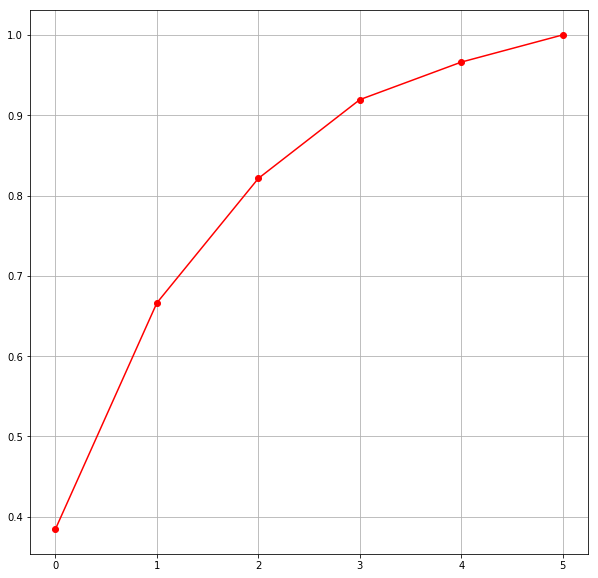

In [55]:
##plot the graph to find the principal components
plt.figure(figsize=(10,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'ro-')
plt.grid()

In [56]:
pca_new = PCA(n_components = 5)
x_new = pca_new.fit_transform(x_train)
explained_variance_new = pca_new.explained_variance_ratio_
print(explained_variance_new)

[0.38466784 0.28166226 0.15498314 0.09808102 0.04674363]


#### 4 PCA component contains 90% variance of Data. And also due to less number of features, will not used PCA vectore for the prediction

In [57]:

# Function to calculate mean absolute error
def f1_score_matric(y_true, y_pred):
    from sklearn.metrics import f1_score
    return f1_score(y_true,y_pred,average='micro')

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model,x_train,y_train,x_test,y_test):
    
    # Train the model
    model.fit(x_train,y_train,)
    
    # Make predictions and evalute
    model_pred = model.predict(x_test)
    print(classification_report(y_test,model_pred))
    # Return the performance metric
    return model,model_pred

## Support Vector Machine

In [58]:
svc = SVC()
svc,svc_pred=fit_and_evaluate(svc,x_train,y_train,x_test,y_test)

             precision    recall  f1-score   support

         A+       0.00      0.00      0.00       572
         B+       0.00      0.00      0.00       602
         C+       0.00      0.00      0.00       637
         D+       0.87      1.00      0.93     11607

avg / total       0.75      0.87      0.80     13418



C:\Users\Rushikesh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [59]:
svc_pred

array(['D+', 'D+', 'D+', ..., 'D+', 'D+', 'D+'], dtype=object)

In [60]:
f1_score_svc=f1_score_matric(y_test, svc_pred)

## Random Forest


### (Selection of number of trees for optimization of random forest model)

In [61]:
n_range=range(1,10)
n_scores=[]
for n in n_range:
    rfc = RandomForestClassifier(n_estimators=n)
    rfc.fit(x_train, y_train)
    pred_rfc = rfc.predict(x_test)
    n_scores.append(accuracy_score(y_test, pred_rfc))
print(n_scores)

[0.765762408704725, 0.6953346251304218, 0.8141302727679237, 0.8130868981964525, 0.8286629900134148, 0.8363392457892384, 0.8424504397078552, 0.8446862423610076, 0.8465494112386347]


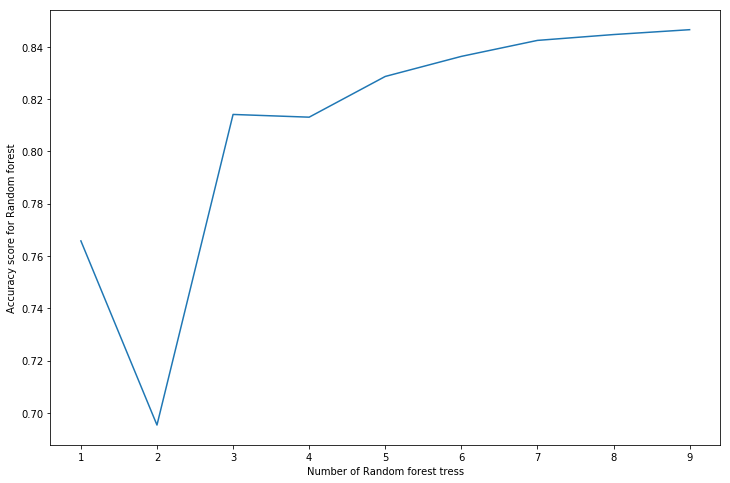

In [62]:
# Plot value of Number of random forest tress verses the cross validation accuracy
plt.plot(n_range,n_scores)
plt.xlabel('Number of Random forest tress')
plt.ylabel('Accuracy score for Random forest')
plt.show()

From above graph, to get accuracy more than 84%, we can select 7 trees for random forest model

In [63]:
rfc = RandomForestClassifier(n_estimators=6)
rfc,rfc_pred=fit_and_evaluate(rfc,x_train,y_train,x_test,y_test)

             precision    recall  f1-score   support

         A+       0.18      0.11      0.14       572
         B+       0.11      0.04      0.06       602
         C+       0.11      0.04      0.05       637
         D+       0.88      0.96      0.92     11607

avg / total       0.78      0.84      0.80     13418



In [64]:
f1_score_rfc=f1_score_matric(y_test,rfc_pred)

## KNN
### Optimization of the number of neighbours(K)

In [65]:
k_range=range(1,10)
k_scores=[]
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train,y_train)
    pred_knn = knn.predict(x_test)
    k_scores.append(accuracy_score(y_test, pred_knn))
print(k_scores)

[0.7779102697868535, 0.7039797287226114, 0.8238187509315844, 0.8285139365032046, 0.8454315099120584, 0.8519898643613057, 0.8583246385452378, 0.8607840214637055, 0.861231181994336]


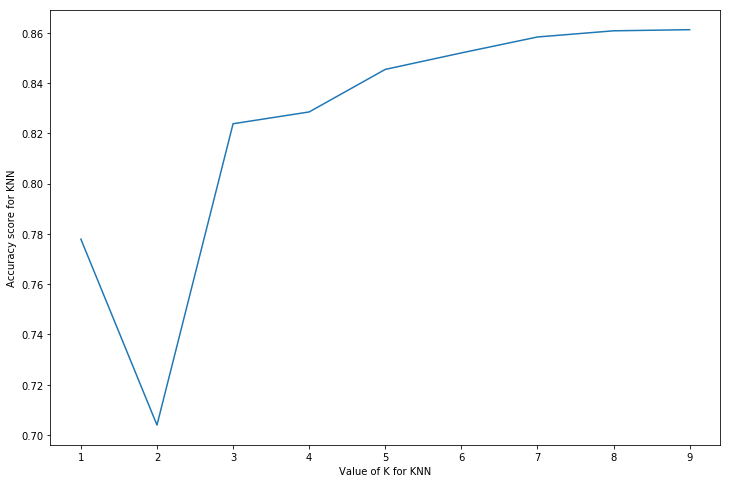

In [66]:
# Plot value of K verses the cross validation accuracy
plt.plot(k_range,k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Accuracy score for KNN')
plt.show()

#### From above graph, we can select k=8 for maximizing the accuracy

In [67]:
knn = KNeighborsClassifier(n_neighbors=8)
knn,knn_pred=fit_and_evaluate(knn,x_train,y_train,x_test,y_test)

             precision    recall  f1-score   support

         A+       0.24      0.05      0.08       572
         B+       0.21      0.01      0.02       602
         C+       0.18      0.01      0.02       637
         D+       0.87      0.99      0.93     11607

avg / total       0.78      0.86      0.81     13418



In [68]:
f1_score_knn=f1_score_matric(y_test,knn_pred)

## Model Comparison

In [69]:
conclusion_accuracies = pd.DataFrame({'models': ["SVC","Random Forest","KNN"],
                           'accuracies': [accuracy_score(y_test,svc_pred),accuracy_score(y_test,rfc_pred),accuracy_score(y_test,knn_pred)]})
conclusion_accuracies

,accuracies,models
0,0.865032,SVC
1,0.836041,Random Forest
2,0.860784,KNN


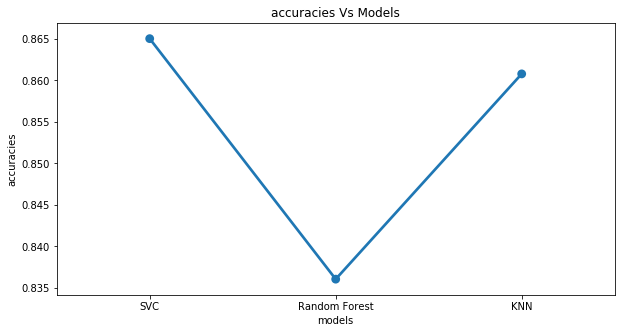

In [70]:
plt.figure(figsize=(10,5))
sns.pointplot(conclusion_accuracies['models'],conclusion_accuracies['accuracies'])
plt.title('accuracies Vs Models')
plt.show()

In [71]:
conclusion_f1_score = pd.DataFrame({'models': ["SVC","Random Forest","KNN"],
                           'f1_score': [f1_score_svc,f1_score_rfc,f1_score_knn]})
conclusion_f1_score

,f1_score,models
0,0.865032,SVC
1,0.836041,Random Forest
2,0.860784,KNN


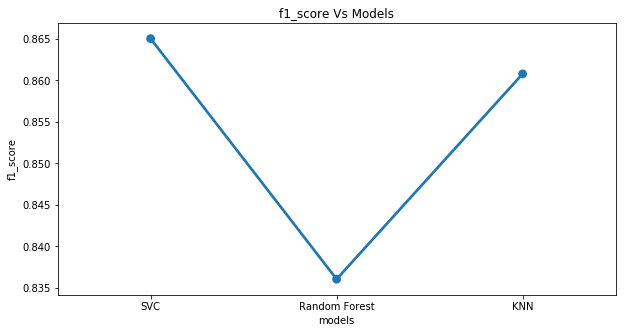

In [72]:
plt.figure(figsize=(10,5))
sns.pointplot(conclusion_f1_score['models'],conclusion_f1_score['f1_score'])
plt.title('f1_score Vs Models')
plt.show()

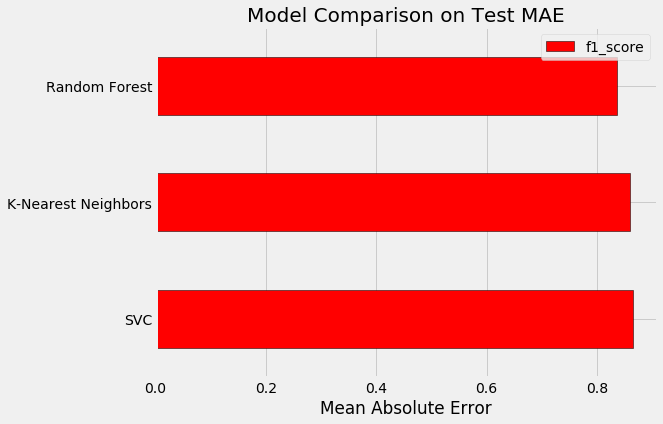

In [73]:
plt.style.use('fivethirtyeight')
figsize(8, 6)

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['SVC','Random Forest','K-Nearest Neighbors'],
                                 'f1_score': [f1_score_svc, f1_score_rfc, f1_score_knn]})

# Horizontal bar chart of test mae
model_comparison.sort_values('f1_score', ascending = False).plot(x = 'model', y = 'f1_score', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20);

### Remarks

- **We can observe that, Support vector classifier and KNN has higher accuracy score followed by Random forest classifier**


- **The F1 score obtained by Support vector classifier model is higher compared to Random forest and KNN model**


- **Support Vector classifier required more computational time, when compared with Random forest and KNN model **


- **All three models have nearly the  same accuracy, Hence we can select all three models for prediction of Grades on test data**


## Test Data

In [74]:
# Read in the data set
df_test = pd.read_csv('Test_data.csv')
df_test.head()

,Sex,Age,Height,Weight,Team,Federation,Event,Year,Season,City,Sub Event,Id,GameID,Game,Record_Id
0,M,19.0,NaN,NaN,France,FRA,1896 Summer,1896,down,Athina,Cycling Men's 333 metres Time Trial,candidate-98663,Game 5,Cycling,0e08dc19-1611-4701-84b2-e67e031febfe
1,M,20.0,NaN,NaN,Great Britain/Germany,GER,1896 Summer,1896,down,Athina,Tennis Men's Doubles,candidate-38391,Game 28,Tennis,16c28bd8-e98e-4faf-9a20-65db7ce7d6b7
2,M,33.0,NaN,NaN,Foxhunters Hurlingham,GBR,1900 Summer,1900,down,Paris,Polo Men's Polo,candidate-4908,Game 55,Polo,d0dbb0f3-c381-415e-a3e3-746f49c764f3
3,M,25.0,NaN,NaN,Union des Socits Franais de Sports Athletiques,FRA,1900 Summer,1900,down,Paris,Rugby Men's Rugby,candidate-12950,Game 53,Rugby,0dd6ebbe-3656-453a-9e96-9923c1b17a67
4,M,21.0,NaN,NaN,Devon and Somerset Wanderers,GBR,1900 Summer,1900,down,Paris,Cricket Men's Cricket,candidate-61508,Game 58,Cricket,9493ce7e-253b-4fec-b3a6-f71acae3273e


In [75]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8974 entries, 0 to 8973
Data columns (total 15 columns):
Sex           8974 non-null object
Age           8664 non-null float64
Height        7015 non-null float64
Weight        6900 non-null float64
Team          8974 non-null object
Federation    8974 non-null object
Event         8974 non-null object
Year          8974 non-null int64
Season        8974 non-null object
City          8974 non-null object
Sub Event     8974 non-null object
Id            8974 non-null object
GameID        8974 non-null object
Game          8974 non-null object
Record_Id     8974 non-null object
dtypes: float64(3), int64(1), object(11)
memory usage: 1.0+ MB


In [76]:
df_test.shape

(8974, 15)

In [77]:
print(df_test.isnull().sum())

Sex              0
Age            310
Height        1959
Weight        2074
Team             0
Federation       0
Event            0
Year             0
Season           0
City             0
Sub Event        0
Id               0
GameID           0
Game             0
Record_Id        0
dtype: int64


#### Test data has missing values, we can used mediun as imputer

#### Merge Population data with test data 

In [78]:
df_test_wpop=df_test.merge(w_pop,left_on = ['Team', 'Year'],
                     right_on= ['Country', 'Year'],how = 'left')

In [79]:
df_test_wpop.shape

(8974, 18)

In [80]:
df_test_wpop=df_test_wpop.drop(columns=['Country','Country Code'])

#### Merge GDP data with test data 

In [81]:
w_gdp.head()

,Country Name,Country Code,Year,GDP
0,Afghanistan,AFG,1960,5.377778e+08
1,Albania,ALB,1960,NaN
2,Algeria,DZA,1960,2.723649e+09
3,American Samoa,ASM,1960,NaN
4,Andorra,AND,1960,NaN


In [82]:
df_test_wpop_gdp=df_test_wpop.merge(w_gdp,left_on = ['Team', 'Year'],
                     right_on= ['Country Name', 'Year'],how = 'left')
df_test_wpop_gdp=df_test_wpop_gdp.drop(columns=['Country Name','Country Code'])

In [83]:
df_test_wpop_gdp.shape

(8974, 17)

#### Missing data

#### Label Encoding

In [84]:
df_test_wpop_gdp['Sex_encode']=label_encoder.transform(df_test_wpop_gdp['Sex'])
df_test_wpop_gdp.head()
df_test_wpop_gdp=df_test_wpop_gdp.drop(columns='Sex')

In [85]:
df_test_wpop_gdp.tail()

,Age,Height,Weight,Team,Federation,Event,Year,Season,City,Sub Event,Id,GameID,Game,Record_Id,Population,GDP,Sex_encode
8969,24.0,175.0,65.0,Italy,ITA,2016 Summer,2016,down,Rio de Janeiro,Swimming Women's 4 x 200 metres Freestyle Relay,candidate-84026,Game 3,Swimming,ad1e3f17-4b9b-4701-a965-f9a8dfd1d430,60600590.0,1.858910e+12,0
8970,21.0,173.0,69.0,Tonga,TGA,2016 Summer,2016,down,Rio de Janeiro,Athletics Men's 100 metres,candidate-114880,Game 1,Athletics,5e337b0b-794f-4244-bcfc-f2f80fc29552,107122.0,4.015620e+08,1
8971,30.0,176.0,76.0,Japan,JPN,2016 Summer,2016,down,Rio de Janeiro,Golf Men's Individual,candidate-132378,Game 50,Golf,bc1f8788-1a1a-4c1b-a756-a89cfc391b71,126994511.0,4.940160e+12,1
8972,24.0,173.0,64.0,Azerbaijan,AZE,2016 Summer,2016,down,Rio de Janeiro,Gymnastics Men's Rings,candidate-100965,Game 2,Gymnastics,3daf7f0c-d9da-453e-aba4-5c4d2c03a7d8,9762274.0,3.784772e+10,1
8973,19.0,175.0,68.0,Czech Republic,CZE,2016 Summer,2016,down,Rio de Janeiro,Gymnastics Men's Parallel Bars,candidate-25532,Game 2,Gymnastics,ebb64927-a3b5-4899-80f7-a548fe475d89,10561633.0,1.953050e+11,1


In [86]:
df_test_wpop_gdp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8974 entries, 0 to 8973
Data columns (total 17 columns):
Age           8664 non-null float64
Height        7015 non-null float64
Weight        6900 non-null float64
Team          8974 non-null object
Federation    8974 non-null object
Event         8974 non-null object
Year          8974 non-null int64
Season        8974 non-null object
City          8974 non-null object
Sub Event     8974 non-null object
Id            8974 non-null object
GameID        8974 non-null object
Game          8974 non-null object
Record_Id     8974 non-null object
Population    5270 non-null float64
GDP           5105 non-null float64
Sex_encode    8974 non-null int64
dtypes: float64(5), int64(2), object(10)
memory usage: 1.2+ MB


### Data preparation

In [87]:
# take the log transforms for the variables
df_test_wpop_gdp['Log_Population'] = np.log(df_test_wpop_gdp['Population'])
df_test_wpop_gdp['Log_GDP'] = np.log(df_test_wpop_gdp['GDP'])

In [88]:
df_test_wpop_gdp_filter=df_test_wpop_gdp[['Age', 'Height', 'Weight', 'Log_Population', 'Log_GDP', 'Sex_encode']]

In [89]:
df_test_wpop_gdp_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8974 entries, 0 to 8973
Data columns (total 6 columns):
Age               8664 non-null float64
Height            7015 non-null float64
Weight            6900 non-null float64
Log_Population    5270 non-null float64
Log_GDP           5105 non-null float64
Sex_encode        8974 non-null int64
dtypes: float64(5), int64(1)
memory usage: 490.8 KB


In [90]:
df_test_wpop_gdp_filter.shape

(8974, 6)

In [91]:
#df_test_wpop_gdp_filter=df_test_wpop_gdp_filter.dropna()

#### Imputation and Scaling

In [92]:
df_test_wpop_gdp_filter=imputer.transform(df_test_wpop_gdp_filter)
x_test_complete=sc_x.transform(df_test_wpop_gdp_filter)

### Prediction

#### Support Vector Classifier

Counter({'D+': 8974})


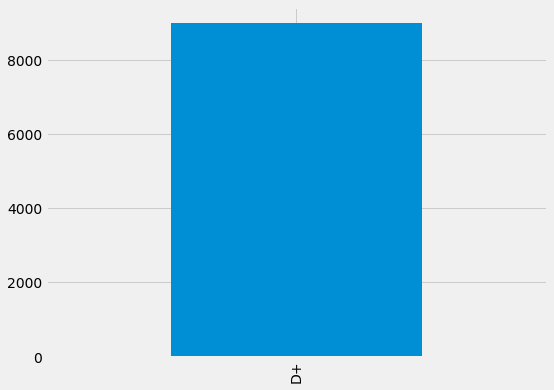

In [93]:
x_prediction_svc=svc.predict(x_test_complete)
df_test_wpop_gdp['Prediction_svc']=x_prediction_svc
print(Counter(df_test_wpop_gdp['Prediction_svc']))
df_test_wpop_gdp['Prediction_svc'].value_counts().plot(kind='bar')

#### Random Forest Classifier

Counter({'D+': 8465, 'A+': 247, 'C+': 139, 'B+': 123})


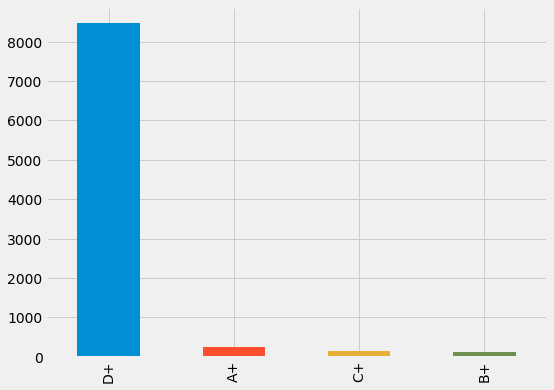

In [94]:
x_prediction_rfc=rfc.predict(x_test_complete)
df_test_wpop_gdp['Prediction_rfc']=x_prediction_rfc
print(Counter(df_test_wpop_gdp['Prediction_rfc']))
df_test_wpop_gdp['Prediction_rfc'].value_counts().plot(kind='bar')

#### K-Nearest Neighbour

Counter({'D+': 8770, 'A+': 109, 'C+': 72, 'B+': 23})


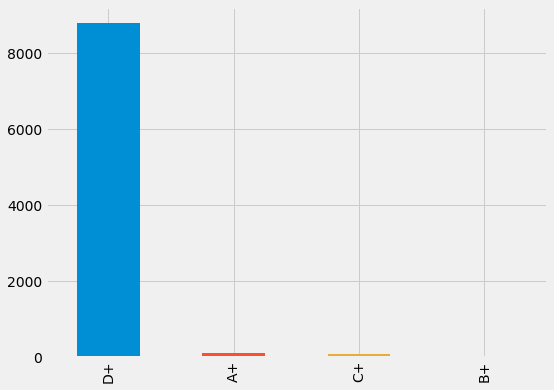

In [95]:
x_prediction_knn=knn.predict(x_test_complete)
df_test_wpop_gdp['Prediction_knn']=x_prediction_knn
print(Counter(df_test_wpop_gdp['Prediction_knn']))
df_test_wpop_gdp['Prediction_knn'].value_counts().plot(kind='bar')

In [98]:
df_test_wpop_gdp.head()

,Age,Height,Weight,Team,Federation,Event,Year,Season,City,Sub Event,...,Game,Record_Id,Population,GDP,Sex_encode,Log_Population,Log_GDP,Prediction_svc,Prediction_rfc,Prediction_knn
0,19.0,NaN,NaN,France,FRA,1896 Summer,1896,down,Athina,Cycling Men's 333 metres Time Trial,...,Cycling,0e08dc19-1611-4701-84b2-e67e031febfe,NaN,NaN,1,NaN,NaN,D+,D+,D+
1,20.0,NaN,NaN,Great Britain/Germany,GER,1896 Summer,1896,down,Athina,Tennis Men's Doubles,...,Tennis,16c28bd8-e98e-4faf-9a20-65db7ce7d6b7,NaN,NaN,1,NaN,NaN,D+,D+,D+
2,33.0,NaN,NaN,Foxhunters Hurlingham,GBR,1900 Summer,1900,down,Paris,Polo Men's Polo,...,Polo,d0dbb0f3-c381-415e-a3e3-746f49c764f3,NaN,NaN,1,NaN,NaN,D+,D+,D+
3,25.0,NaN,NaN,Union des Socits Franais de Sports Athletiques,FRA,1900 Summer,1900,down,Paris,Rugby Men's Rugby,...,Rugby,0dd6ebbe-3656-453a-9e96-9923c1b17a67,NaN,NaN,1,NaN,NaN,D+,D+,D+
4,21.0,NaN,NaN,Devon and Somerset Wanderers,GBR,1900 Summer,1900,down,Paris,Cricket Men's Cricket,...,Cricket,9493ce7e-253b-4fec-b3a6-f71acae3273e,NaN,NaN,1,NaN,NaN,D+,D+,D+


#### Output

In [97]:
df_test_wpop_gdp.to_csv('Classification_Grades.csv')

### Remark:
- From above, we have observed that during training accuracy score has slightly different for all 3 models SVC, RFC and KNN algorithm with 6 components. All three models has been tuned, trained using train data set and tested on test data set. Support vector classifier model has higher accuracy score when compared with Random forest and KNN. 

- SVC has predicted only D+ class on test data, while RFC and KNN has mixed class prediction, need further to investigate




### Conclusion
In this notebook, we carried out the first below steps of a machine learning problem:

1.Cleaned and formatted the raw data

2.Performed an exploratory data analysis

3.Developed a set of features to train our model using feature engineering and feature selection

4.Prediction of Grades has been done considering classification problem (Class A, B, C and D)


**For classification, we have seen Support vector classifier has better accuracy compared to other two models (Random forestand KNN) without considering the PCA**






###  Further Enhanement/Exploration:
   - Handle Imbalce class :Data is highly imbalanced, we can explore few techniques like SMOTE  or upsampling or downsampling of class
   
   - Reduce category: we can create new class which will combination of A+, B+ and C+ and explore further
   
   - Try more model: We can explore new algorithm for classification
   
   - Missing data handling: Here I have tried mediun as imputer,  we can explore new method and do further analysis
   
   - Season category : Data can be segregated  as season-wise and do the further analysis
   
   - Hyper Parameter tuning: We can tune the hyperparameter of models to improve the accuracy
    